In [52]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from read_telega_dump import telega_dump_to_pandas


tlg_group_id = -1001688539638 
# telegram group id, can be taken from "copy message link"  in desctop telegram

### we can use either of the cells below to load data from dump

In [53]:
dump_path = r"D:\test_data\ChatExport_2024-03-14\result.json"
df = telega_dump_to_pandas(dump_path=dump_path)
# note: for data, taken from "export chat history", we do not have number of reactions 


In [54]:
tlg_group_id = -1001688539638
file_path = rf'data\chat{tlg_group_id}.parquet.gzip'
df =pd.read_parquet(file_path)
df.shape

(144835, 10)

In [55]:
df.dtypes

is_question                       bool
user_name                       object
msg_text                        object
msg_len                          int64
reply_to_msg_id                float64
react_cnt                        int64
user_id                          int64
msg_id                           int64
msg_date           datetime64[ns, UTC]
msg_month_key                 category
dtype: object

### Overall statistics

In [56]:
df['dummi'] = 1 # there should be less ugly way to get different aggegations without grouping
agg_df = df.groupby('dummi').aggregate({'msg_id':'count','msg_date':['min','max'], 'user_id': 'nunique'}).reset_index()
msgs_cnt = agg_df[( 'msg_id', 'count')][0]
min_date = agg_df[('msg_date', 'min')][0]
max_date = agg_df[('msg_date', 'max')][0]
number_of_days = (max_date-min_date).days
unique_users =  agg_df[('user_id', 'nunique')][0]
del df['dummi'] 
cols = ["Metric name", "Value"]
dt_format = "%Y-%m-%d"
d_report = [
    {cols[0]: "Number or messages", cols[1]: msgs_cnt},
    {cols[0]: "Date interval", cols[1]: f'from {min_date.strftime(dt_format)} to {max_date.strftime(dt_format)}' },
    {cols[0]: "Users count", cols[1]: unique_users },
    {cols[0]: "Avg messages per day", cols[1]: round(msgs_cnt/number_of_days , 1) },
    ]
pd.DataFrame.from_dict(d_report)






,Metric name,Value
0,Number or messages,144835
1,Date interval,from 2022-03-05 to 2024-03-20
2,Users count,1313
3,Avg messages per day,194.1


### assign date range if you want to restict dataset to some particular period for futher analysis, or just ignore the cell below 

In [57]:
tm_zn = 'Europe/Istanbul'
dt_range = (pd.Timestamp(year=2022, month=2, day=23, tz=tm_zn), pd.Timestamp(datetime.now(), tz=tm_zn))           
number_of_days = (dt_range[1]-dt_range[0]).days
df = df[df.msg_date.between(*dt_range)]


### aggregations by date

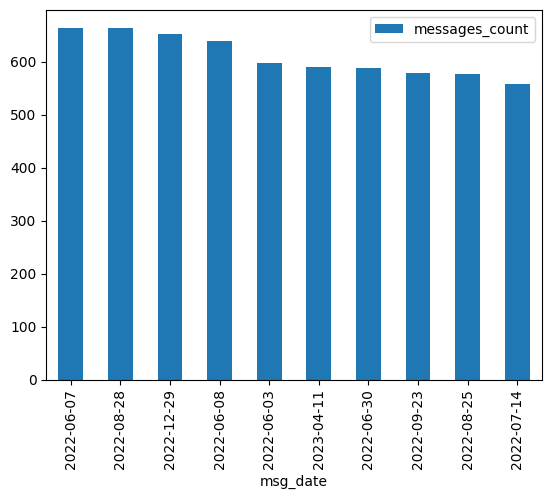

In [58]:
df_aggr = df.groupby(df.msg_date.dt.date).size().sort_values(ascending=False).reset_index(name='messages_count')
df_aggr[0:10].plot(x='msg_date', y='messages_count',kind='bar')
plt.show()

<Axes: >

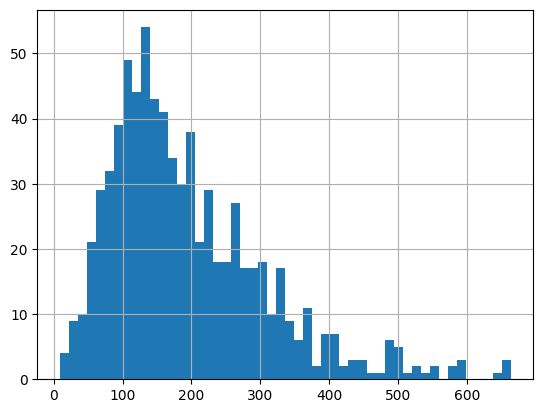

In [59]:
# Visualize the distribution of count of messages per day
df_aggr.messages_count.hist(bins=50)

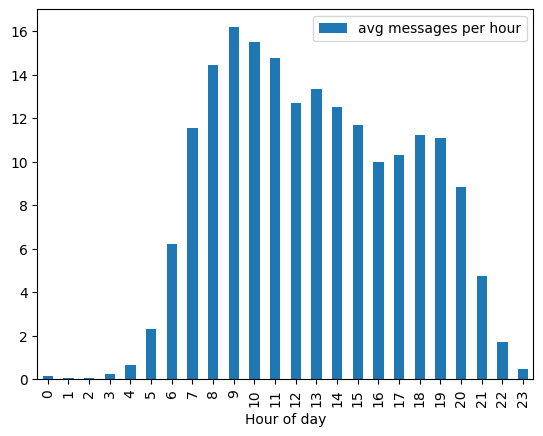

In [60]:
df_aggr = df.groupby(df.msg_date.dt.hour).size().reset_index(name='messages_count')
df_aggr['messages_count'] =  round(df_aggr['messages_count']/number_of_days, 2)
df_aggr = df_aggr.rename(columns={'msg_date': 'Hour of day', 'messages_count': 'avg messages per hour'})
df_aggr[0:24].plot(x='Hour of day', y='avg messages per hour',kind='bar')
plt.show()

### Aggregations by user

Choose metric to play around
- Number of messages
- Length of message
- Number of reactions 
- Number of questions
- Number of answers to some questions


Aggegations

In [182]:
aggs = {'msg_id':'count',
        'msg_date':['min','max'],
        'react_cnt': 'sum',
        'msg_len': 'mean',
        "is_question": 'sum'
        }
agg_df = df.groupby('user_id').aggregate(aggs).reset_index()
agg_df.columns


MultiIndex([(    'user_id',      ''),
            (     'msg_id', 'count'),
            (   'msg_date',   'min'),
            (   'msg_date',   'max'),
            (  'react_cnt',   'sum'),
            (    'msg_len',  'mean'),
            ('is_question',   'sum')],
           )

In [183]:
# flattening of column MultiIndex
if  isinstance(agg_df.columns, pd.MultiIndex):
    agg_df.columns = ['_'.join(col).rstrip('_') if col[1] else col[0] for col in agg_df.columns]
agg_df.columns


Index(['user_id', 'msg_id_count', 'msg_date_min', 'msg_date_max',
       'react_cnt_sum', 'msg_len_mean', 'is_question_sum'],
      dtype='object')

### Calculations for different metrics

In [184]:
# calculations

msg_cnt_s = agg_df['msg_id_count']

agg_df['activity_days'] = (agg_df ['msg_date_max'] - agg_df ['msg_date_min']).dt.days+1
agg_df['reactions_per_mess'] = agg_df['react_cnt_sum']/msg_cnt_s
agg_df['mess_per_day'] = msg_cnt_s/agg_df['activity_days']
agg_df['%_of_questions'] = agg_df['is_question_sum']/msg_cnt_s
agg_df.head(10)

,user_id,msg_id_count,msg_date_min,msg_date_max,react_cnt_sum,msg_len_mean,is_question_sum,activity_days,reactions_per_mess,mess_per_day,%_of_questions
0,20199,10,2022-04-06 14:09:06+00:00,2022-04-16 11:59:02+00:00,1,43.300000,4,10,0.100000,1.000000,0.400000
1,59814,5,2022-04-12 19:50:18+00:00,2022-05-16 21:37:42+00:00,4,139.400000,0,35,0.800000,0.142857,0.000000
2,249764,1,2023-11-11 09:20:32+00:00,2023-11-11 09:20:32+00:00,1,21.000000,0,1,1.000000,1.000000,0.000000
3,259478,205,2022-10-14 17:58:11+00:00,2023-04-15 11:10:23+00:00,51,67.263415,34,183,0.248780,1.120219,0.165854
4,268725,235,2022-06-09 12:19:08+00:00,2022-12-21 16:09:06+00:00,59,53.548936,67,196,0.251064,1.198980,0.285106
5,285150,1,2022-05-08 12:05:18+00:00,2022-05-08 12:05:18+00:00,0,202.000000,1,1,0.000000,1.000000,1.000000
6,345383,4,2022-11-10 11:14:12+00:00,2023-02-06 21:51:33+00:00,0,90.250000,3,89,0.000000,0.044944,0.750000
7,361816,8,2022-06-30 11:16:33+00:00,2022-07-13 08:05:39+00:00,1,67.500000,3,13,0.125000,0.615385,0.375000
8,555411,1218,2022-05-22 06:36:08+00:00,2024-03-19 12:01:52+00:00,453,89.133005,304,668,0.371921,1.823353,0.249589
9,713052,4,2022-11-07 07:25:20+00:00,2023-09-01 17:06:07+00:00,1,448.250000,0,299,0.250000,0.013378,0.000000


In [185]:
rank_metricks = [
     'msg_id_count',
     'msg_len_mean',
     'reactions_per_mess',
     '%_of_questions',  
]
for m in rank_metricks:
   agg_df['rn_' + m] = agg_df[m].rank(ascending=False).astype('int')
   

In [191]:
agg_df.head(10)
agg_df.columns


Index(['user_id', 'username', 'first_name', 'msg_id_count', 'msg_date_min',
       'msg_date_max', 'react_cnt_sum', 'msg_len_mean', 'is_question_sum',
       'activity_days', 'reactions_per_mess', 'mess_per_day', '%_of_questions',
       'rn_msg_id_count', 'rn_msg_len_mean', 'rn_reactions_per_mess',
       'rn_%_of_questions'],
      dtype='object')

#### JOIN to user names

In [187]:
users_dump = r'data\participants.json'
usrs_df = pd.read_json(users_dump)
agg_df = pd.merge(usrs_df, agg_df , on='user_id')

## Answering the questions


In [209]:
def display_helper(col_sort: str):
    """['user_id', 'username', 'first_name', 'msg_id_count', 'msg_date_min',
       'msg_date_max', 'react_cnt_sum', 'msg_len_mean', 'is_question_sum',
       'activity_days', 'reactions_per_mess', 'mess_per_day', '%_of_questions',
       'rn_msg_id_count', 'rn_msg_len_mean', 'rn_reactions_per_mess',
       'rn_%_of_questions']"""
    displ_cols =  ['rn_'+col_sort], 'user_id', 'username', col_sort]
    sort_2_display = {
        'msg_id_count': ['activity_days',   'mess_per_day', 'rn_msg_len_mean', 'rn_reactions_per_mess'],   
        'msg_len_mean': [ 'activity_days', 'msg_id_count',  'mess_per_day', 'rn_reactions_per_mess'], 
        'reactions_per_mess': [ 'activity_days', 'msg_id_count',  'mess_per_day', 'rn_msg_id_count', 'rn_msg_len_mean', 'rn_%_of_questions'], 
                    }
    cols_plus = sort_2_display.get(col_sort)
    if cols_plus:
        displ_cols.extend(cols_plus)
        filt = agg_df['msg_id_count'] > 20 # to get rid of non active users, that spoils the picture
    return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)

### Who has written the most posts?


In [210]:

display_helper('msg_id_count')

C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_30756\722953068.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,user_id,username,msg_id_count,rn_msg_id_count,activity_days,mess_per_day,rn_msg_len_mean,rn_reactions_per_mess
0,52026345,Kotyakleo,12723,1,677,18.793205,1126,521
20,190329073,nightroadman,6722,2,743,9.047106,1204,317
2,881257459,Elmanov_Anton,5235,3,688,7.609012,310,327
62,547589961,andrei_tig,4640,4,680,6.823529,841,314
17,179639849,nishaforostov,3943,5,706,5.584986,557,468
109,444962569,JunkLock,3897,6,712,5.473315,732,414
36,596414076,sergeibodulin,3453,7,686,5.033528,1102,346
44,1717751452,vorchuh,3339,8,731,4.567715,716,670
49,170608510,maksibon,2405,9,699,3.440629,632,546
81,10415960,padavanchik,2319,10,670,3.461194,1182,507


### Who wrote the longest posts?

In [205]:
display_helper('msg_len_mean')


C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_30756\2358121059.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,user_id,username,msg_len_mean,activity_days,msg_id_count,mess_per_day,rn_msg_len_mean,rn_reactions_per_mess
274,327880249,AlexStarD,308.225000,586,40,0.068259,28,122
463,67432026,PapoELF,294.208333,196,24,0.122449,36,69
186,328364852,RKhalilyullov,247.227273,511,22,0.043053,50,123
208,341969325,redblackbravo,232.651163,625,43,0.068800,56,15
298,989087781,mlv0v,227.604167,596,48,0.080537,60,178
676,448678958,Bodya_Positive,216.352941,125,34,0.272000,67,408
407,114853619,anton_lanit,212.083333,361,84,0.232687,69,412
508,337869866,i_amolga,207.571429,23,28,1.217391,77,310
204,1026659931,polya_magerchuk,205.854545,677,55,0.081241,78,435
344,426773250,denispepper,204.972222,506,36,0.071146,79,205


### Whose messages get the most reactions

In [206]:
display_helper('reactions_per_mess')

C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_30756\2358121059.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,user_id,username,reactions_per_mess,activity_days,msg_id_count,mess_per_day,rn_msg_id_count,rn_msg_len_mean,rn_%_of_questions
208,341969325,redblackbravo,1.046512,625,43,0.068800,338,56,1053
463,67432026,PapoELF,0.833333,196,24,0.122449,476,36,584
400,125955681,iliyaking46,0.633333,499,30,0.060120,421,174,742
105,378288885,a_lina_lee,0.629870,515,154,0.299029,142,567,946
154,379152094,VolterraLotka,0.627219,272,169,0.621324,133,328,1107
75,101881219,galya_ctrl_z,0.625000,225,24,0.106667,476,317,868
623,1167536204,Nenikeeva,0.619048,104,21,0.201923,511,684,814
188,158197633,graynolf,0.603448,439,58,0.132118,275,1108,1071
427,716657753,nzpolly,0.590909,47,22,0.468085,501,855,1112
221,447458320,amoschov,0.571429,40,70,1.750000,239,177,983
